# Project on 
## **Sentiment Analysis On Movie Reviews**

---



In [27]:
!pip install pyprind
!pip install torch==1.6.0 torchvision==0.7.0 torchtext==0.7.0

In [28]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
import torchtext
import torch.nn.functional as F
import torch.nn as nn
import pyprind
#%matplotlib inline  
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
is_cuda = torch.cuda.is_available()
print("Cuda Status on system is {}".format(is_cuda))
print(torch.cuda.get_device_name())

Cuda Status on system is True
Tesla T4


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Preparation  of Dataset


In [31]:
df = pd.read_csv("/content/drive/MyDrive/Movie/movie_review.csv")
df

,fold_id,cv_tag,html_id,sent_id,text,tag
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos
...,...,...,...,...,...,...
64715,9,cv999,14636,20,that lack of inspiration can be traced back to...,neg
64716,9,cv999,14636,21,like too many of the skits on the current inca...,neg
64717,9,cv999,14636,22,"after watching one of the "" roxbury "" skits on...",neg
64718,9,cv999,14636,23,"bump unsuspecting women , and . . . that's all .",neg


Shape of dataset

In [32]:
print(df.shape)
df=df.dropna()
print(df.shape)

(64720, 6)
(64720, 6)


Replacing the 'positive' tag with 1 and 'negative' with 0

In [33]:
df["tag"].replace({"pos":int(1),"neg":int(0)},inplace=True) 
X=df['text']
y=df['tag']

Splitting the Test Train Dataset

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train,X_valid,y_train,y_valid=train_test_split(X_train, y_train, test_size=0.10, random_state=42)

print(f'Size of Train set {X_train.shape}\nSize of Test set {X_test.shape}\nSize of valid set {X_valid.shape}\n')

Size of Train set (52423,)
Size of Test set (6472,)
Size of valid set (5825,)



In [35]:
train = pd.concat([X_train, y_train], axis=1)
print(train.shape)

test = pd.concat([X_test, y_test], axis=1)
print(test.shape)

valid = pd.concat([X_valid, y_valid], axis=1)
print(valid.shape)

(52423, 2)
(6472, 2)
(5825, 2)


In [36]:
train.to_csv("/content/drive/My Drive/train.csv", index=False)
test.to_csv("/content/drive/My Drive/test.csv", index=False)
valid.to_csv("/content/drive/My Drive/valid.csv", index=False)

In [37]:
del df,train, test, valid, X_train, y_train,X_valid,y_valid, X_test, y_test

Tokenizing Dataset and using Pytorchtext


In [38]:
def tokenizer(text):
    return [tok for tok in nltk.word_tokenize(text)]

In [39]:
from torchtext import data
TEXT = data.Field(sequential=True, tokenize=tokenizer,include_lengths = True)
LABEL = data.LabelField(dtype=torch.float, sequential=False)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [40]:
train_data, valid_data, test_data = data.TabularDataset.splits(
    path="/content/drive/My Drive/", train="train.csv", 
    validation="valid.csv", test="test.csv",format="csv", skip_header=True, 
    fields=[('text', TEXT), ('tag', LABEL)]
)
#change 

/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


In [41]:
TEXT.build_vocab(train_data, vectors=torchtext.vocab.Vectors("/content/drive/My Drive/Movie/glove.840B.300d.txt"), 
                 max_size=50000)
LABEL.build_vocab(train_data)

# For Setting1:
**Hyperparameters:**


*   Epoch number=5
*   Learning rate=0.001
*   batch size= 8
*   Number of nodes in hidden layer= 100





In [66]:
# Hyperparameters
num_epochs = 5
learning_rate = 0.001

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 100
OUTPUT_DIM = 1
#N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding
BATCH_SIZE = 8

In [67]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# keep in mind the sort_key option 
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), sort_key=lambda x: len(x.text),sort_within_batch = True,
    batch_size=BATCH_SIZE,
    device=device)

cuda:0


/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [68]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        # embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                
        #hidden = [batch size, hid dim * num directions]
            
        return output

In [69]:
#creating instance of our LSTM_net class

model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM,  
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [70]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([42704, 300])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0828,  0.6720, -0.1499,  ..., -0.1918, -0.3785, -0.0659],
        ...,
        [-0.3498,  0.4714,  0.3338,  ...,  0.2062,  0.1383,  0.1018],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1034,  0.0618, -0.3565,  ..., -0.0621, -0.5939, -0.1527]])

In [71]:
#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0828,  0.6720, -0.1499,  ..., -0.1918, -0.3785, -0.0659],
        ...,
        [-0.3498,  0.4714,  0.3338,  ...,  0.2062,  0.1383,  0.1018],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1034,  0.0618, -0.3565,  ..., -0.0621, -0.5939, -0.1527]])


In [72]:
model.to(device) #CNN to GPU


# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [73]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [74]:
# training function 
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    bar = pyprind.ProgBar(len(iterator), bar_char='█')
    for batch in iterator:
        
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.tag)
        acc = binary_accuracy(predictions, batch.tag)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        bar.update()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [75]:
def evaluate(model, iterator,mode):
    
    epoch_acc = 0
    epoch_loss=0
    preds,labels=[],[]
    model.eval()
    
    with torch.no_grad():
        bar = pyprind.ProgBar(len(iterator), bar_char='█')
        for batch in iterator:
            
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.tag)
            loss = criterion(predictions, batch.tag)
            
            rounded_preds = torch.round(torch.sigmoid(predictions))
            logits = rounded_preds.detach().cpu().numpy()
            label_ids = batch.tag.to('cpu').numpy()
            
            preds.append(logits)
            labels.append(label_ids)

            epoch_acc += acc.item()
            epoch_loss+=loss.item()
            bar.update()
    if mode =="validation":        
      return epoch_acc / len(iterator),epoch_loss / len(iterator)
    if mode =="testing":
      return epoch_acc / len(iterator),epoch_loss / len(iterator),preds,labels

In [76]:
t = time.time()
loss=[]
acc=[]
val_acc=[]
val_loss=[]
same_loss_count=0
prev_loss = 0
for epoch in range(num_epochs):
    print(f'Epoch Number: {epoch}\n')
    train_loss, train_acc = train(model, train_iterator)
    valid_acc,valid_loss = evaluate(model, valid_iterator,"validation")

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')
    
    #print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    val_loss.append(valid_loss)
    
    if np.abs(prev_loss-valid_loss)<0.001:
      same_loss_count+=1

    prev_loss=valid_loss
    if same_loss_count == 3:
      break
      
print(f'time:{time.time()-t:.3f}')

Epoch Number: 0



/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.606 | Train Acc: 65.77%
	Val. Loss: 0.545 | Val. Acc: 71.98%
Epoch Number: 1




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.441 | Train Acc: 77.59%
	Val. Loss: 0.540 | Val. Acc: 73.06%
Epoch Number: 2




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:05
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.330 | Train Acc: 83.45%
	Val. Loss: 0.566 | Val. Acc: 72.39%
Epoch Number: 3




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:05
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.244 | Train Acc: 87.36%
	Val. Loss: 0.724 | Val. Acc: 71.74%
Epoch Number: 4




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.183 | Train Acc: 90.32%
	Val. Loss: 0.900 | Val. Acc: 70.71%
time:337.496



Total time elapsed: 00:00:01


<function matplotlib.pyplot.show>

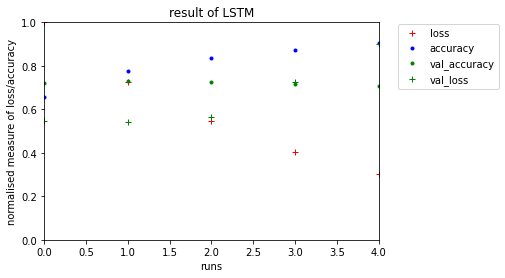

In [77]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(val_loss)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of LSTM')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r+',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.plot(x_len, val_loss, 'g+', label="val_loss")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

In [78]:
test_acc,test_loss,preds,labels = evaluate(model, test_iterator,"testing")

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [79]:
print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

	Test Loss: 0.950 | Test Acc: 70.29%


In [80]:
preds = np.concatenate(preds)
labels = np.concatenate(labels)

prc,rec,fs = precision_score(labels,preds),recall_score(labels,preds),f1_score(labels,preds)

In [81]:
print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Precision: {prc*100:.2f}% | Recall: {rec*100:.2f}% | F1-Score: {fs*100:.2f}%')

	Test Loss: 0.950 | Test Acc: 70.29% | Precision: 67.97% | Recall: 75.39% | F1-Score: 71.49%


# For Setting2: 
**Hyperparameters:**
*   Epoch number=10
*   Learning rate=0.001
*   batch size= 8
*   Number of nodes in hidden layer = 150

In [82]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
OUTPUT_DIM = 1
#N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding
BATCH_SIZE = 8

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# keep in mind the sort_key option 
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), sort_key=lambda x: len(x.text),sort_within_batch = True,
    batch_size=BATCH_SIZE,
    device=device)

class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        # embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                
        #hidden = [batch size, hid dim * num directions]
            
        return output

#creating instance of our LSTM_net class

model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM,  
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


model.to(device) #CNN to GPU
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

# training function 
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    bar = pyprind.ProgBar(len(iterator), bar_char='█')
    for batch in iterator:
        
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.tag)
        acc = binary_accuracy(predictions, batch.tag)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        bar.update()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator,mode):
    
    epoch_acc = 0
    epoch_loss=0
    preds,labels=[],[]
    model.eval()
    
    with torch.no_grad():
        bar = pyprind.ProgBar(len(iterator), bar_char='█')
        for batch in iterator:
            
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.tag)
            loss = criterion(predictions, batch.tag)
            
            rounded_preds = torch.round(torch.sigmoid(predictions))
            logits = rounded_preds.detach().cpu().numpy()
            label_ids = batch.tag.to('cpu').numpy()
            
            preds.append(logits)
            labels.append(label_ids)

            epoch_acc += acc.item()
            epoch_loss+=loss.item()
            bar.update()
    if mode =="validation":        
      return epoch_acc / len(iterator),epoch_loss / len(iterator)
    if mode =="testing":
      return epoch_acc / len(iterator),epoch_loss / len(iterator),preds,labels

t = time.time()
loss=[]
acc=[]
val_acc=[]
val_loss=[]
same_loss_count=0
prev_loss = 0
for epoch in range(num_epochs):
    print(f'Epoch Number: {epoch}\n')
    train_loss, train_acc = train(model, train_iterator)
    valid_acc,valid_loss = evaluate(model, valid_iterator,"validation")

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')
    
    #print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    val_loss.append(valid_loss)
    
    if np.abs(prev_loss-valid_loss)<0.001:
      same_loss_count+=1

    prev_loss=valid_loss
    if same_loss_count == 3:
      break
      
print(f'time:{time.time()-t:.3f}')



cuda:0
Epoch Number: 0



/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to 

	Train Loss: 0.606 | Train Acc: 65.82%
	Val. Loss: 0.544 | Val. Acc: 72.74%
Epoch Number: 1




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.442 | Train Acc: 77.76%
	Val. Loss: 0.528 | Val. Acc: 73.32%
Epoch Number: 2




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.323 | Train Acc: 83.75%
	Val. Loss: 0.566 | Val. Acc: 73.22%
Epoch Number: 3




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.239 | Train Acc: 87.69%
	Val. Loss: 0.697 | Val. Acc: 72.22%
Epoch Number: 4




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.178 | Train Acc: 90.59%
	Val. Loss: 0.978 | Val. Acc: 70.68%
Epoch Number: 5




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.141 | Train Acc: 92.06%
	Val. Loss: 1.279 | Val. Acc: 71.09%
Epoch Number: 6




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.120 | Train Acc: 93.00%
	Val. Loss: 1.325 | Val. Acc: 71.18%
Epoch Number: 7




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.109 | Train Acc: 93.44%
	Val. Loss: 1.308 | Val. Acc: 69.84%
Epoch Number: 8




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.102 | Train Acc: 93.82%
	Val. Loss: 1.431 | Val. Acc: 70.59%
Epoch Number: 9




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.098 | Train Acc: 93.82%
	Val. Loss: 1.231 | Val. Acc: 69.46%
time:677.653



Total time elapsed: 00:00:01


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


	Test Loss: 1.282 | Test Acc: 68.54%
	Test Loss: 1.282 | Test Acc: 68.54% | Precision: 69.25% | Recall: 65.35% | F1-Score: 67.25%


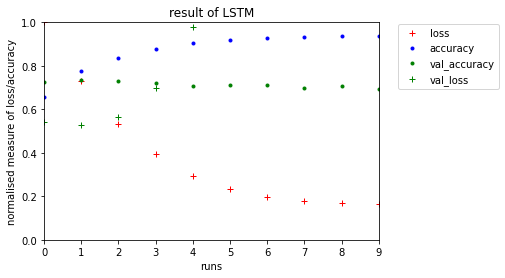

In [83]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(val_loss)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of LSTM')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r+',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.plot(x_len, val_loss, 'g+', label="val_loss")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show


test_acc,test_loss,preds,labels = evaluate(model, test_iterator,"testing")

print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
preds = np.concatenate(preds)
labels = np.concatenate(labels)

prc,rec,fs = precision_score(labels,preds),recall_score(labels,preds),f1_score(labels,preds)
print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Precision: {prc*100:.2f}% | Recall: {rec*100:.2f}% | F1-Score: {fs*100:.2f}%')

# For Setting3: 
**Hyperparameters:**
*   Epoch number=15
*   Learning rate=0.001
*   batch size= 8
*   Number of nodes in hidden layer = 200

In [84]:
# Hyperparameters
num_epochs = 15
learning_rate = 0.001

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 200
OUTPUT_DIM = 1
#N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding
BATCH_SIZE = 8

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# keep in mind the sort_key option 
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), sort_key=lambda x: len(x.text),sort_within_batch = True,
    batch_size=BATCH_SIZE,
    device=device)

class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        # embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                
        #hidden = [batch size, hid dim * num directions]
            
        return output

#creating instance of our LSTM_net class

model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM,  
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


model.to(device) #CNN to GPU
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

# training function 
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    bar = pyprind.ProgBar(len(iterator), bar_char='█')
    for batch in iterator:
        
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.tag)
        acc = binary_accuracy(predictions, batch.tag)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        bar.update()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator,mode):
    
    epoch_acc = 0
    epoch_loss=0
    preds,labels=[],[]
    model.eval()
    
    with torch.no_grad():
        bar = pyprind.ProgBar(len(iterator), bar_char='█')
        for batch in iterator:
            
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.tag)
            loss = criterion(predictions, batch.tag)
            
            rounded_preds = torch.round(torch.sigmoid(predictions))
            logits = rounded_preds.detach().cpu().numpy()
            label_ids = batch.tag.to('cpu').numpy()
            
            preds.append(logits)
            labels.append(label_ids)

            epoch_acc += acc.item()
            epoch_loss+=loss.item()
            bar.update()
    if mode =="validation":        
      return epoch_acc / len(iterator),epoch_loss / len(iterator)
    if mode =="testing":
      return epoch_acc / len(iterator),epoch_loss / len(iterator),preds,labels

t = time.time()
loss=[]
acc=[]
val_acc=[]
val_loss=[]
same_loss_count=0
prev_loss = 0
for epoch in range(num_epochs):
    print(f'Epoch Number: {epoch}\n')
    train_loss, train_acc = train(model, train_iterator)
    valid_acc,valid_loss = evaluate(model, valid_iterator,"validation")

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')
    
    #print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    val_loss.append(valid_loss)
    
    if np.abs(prev_loss-valid_loss)<0.001:
      same_loss_count+=1

    prev_loss=valid_loss
    if same_loss_count == 3:
      break
      
print(f'time:{time.time()-t:.3f}')



cuda:0
Epoch Number: 0



/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to 

	Train Loss: 0.606 | Train Acc: 65.71%
	Val. Loss: 0.541 | Val. Acc: 72.14%
Epoch Number: 1



0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.443 | Train Acc: 77.64%
	Val. Loss: 0.525 | Val. Acc: 73.22%
Epoch Number: 2




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


	Train Loss: 0.329 | Train Acc: 83.49%
	Val. Loss: 0.560 | Val. Acc: 71.98%
Epoch Number: 3



0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.244 | Train Acc: 87.67%
	Val. Loss: 0.723 | Val. Acc: 72.03%
Epoch Number: 4




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:08
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.182 | Train Acc: 90.36%
	Val. Loss: 0.883 | Val. Acc: 69.82%
Epoch Number: 5




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:07
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.143 | Train Acc: 92.15%
	Val. Loss: 0.996 | Val. Acc: 69.65%
Epoch Number: 6




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.123 | Train Acc: 92.89%
	Val. Loss: 1.260 | Val. Acc: 70.06%
Epoch Number: 7




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.111 | Train Acc: 93.44%
	Val. Loss: 1.186 | Val. Acc: 69.10%
Epoch Number: 8




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.102 | Train Acc: 93.94%
	Val. Loss: 1.427 | Val. Acc: 68.71%
Epoch Number: 9




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.101 | Train Acc: 93.62%
	Val. Loss: 1.870 | Val. Acc: 69.14%
Epoch Number: 10




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.094 | Train Acc: 94.11%
	Val. Loss: 1.971 | Val. Acc: 69.72%
Epoch Number: 11




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.095 | Train Acc: 94.04%
	Val. Loss: 1.609 | Val. Acc: 68.48%
Epoch Number: 12




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.091 | Train Acc: 94.32%
	Val. Loss: 1.653 | Val. Acc: 69.65%
Epoch Number: 13




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.093 | Train Acc: 94.03%
	Val. Loss: 1.851 | Val. Acc: 68.86%
Epoch Number: 14




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


	Train Loss: 0.089 | Train Acc: 94.35%
	Val. Loss: 1.901 | Val. Acc: 68.66%
time:1023.427


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


	Test Loss: 1.913 | Test Acc: 69.10%
	Test Loss: 1.913 | Test Acc: 69.10% | Precision: 70.26% | Recall: 64.95% | F1-Score: 67.50%


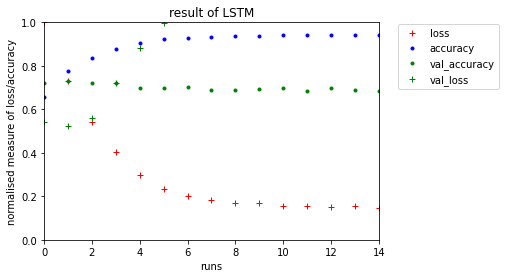

In [85]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(val_loss)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of LSTM')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r+',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.plot(x_len, val_loss, 'g+', label="val_loss")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show


test_acc,test_loss,preds,labels = evaluate(model, test_iterator,"testing")

print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
preds = np.concatenate(preds)
labels = np.concatenate(labels)

prc,rec,fs = precision_score(labels,preds),recall_score(labels,preds),f1_score(labels,preds)
print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Precision: {prc*100:.2f}% | Recall: {rec*100:.2f}% | F1-Score: {fs*100:.2f}%')

# For Setting4: 
**Hyperparameters:**
*   Epoch number=6
*   Learning rate=0.0005
*   batch size= 16
*   Number of nodes in hidden layer = 300

In [88]:
# Hyperparameters
num_epochs = 6
learning_rate = 0.0005

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
OUTPUT_DIM = 1
#N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding
BATCH_SIZE = 16

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# keep in mind the sort_key option 
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), sort_key=lambda x: len(x.text),sort_within_batch = True,
    batch_size=BATCH_SIZE,
    device=device)

class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        # embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                
        #hidden = [batch size, hid dim * num directions]
            
        return output

#creating instance of our LSTM_net class

model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM,  
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


model.to(device) #CNN to GPU
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

# training function 
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    bar = pyprind.ProgBar(len(iterator), bar_char='█')
    for batch in iterator:
        
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.tag)
        acc = binary_accuracy(predictions, batch.tag)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        bar.update()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator,mode):
    
    epoch_acc = 0
    epoch_loss=0
    preds,labels=[],[]
    model.eval()
    
    with torch.no_grad():
        bar = pyprind.ProgBar(len(iterator), bar_char='█')
        for batch in iterator:
            
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.tag)
            loss = criterion(predictions, batch.tag)
            
            rounded_preds = torch.round(torch.sigmoid(predictions))
            logits = rounded_preds.detach().cpu().numpy()
            label_ids = batch.tag.to('cpu').numpy()
            
            preds.append(logits)
            labels.append(label_ids)

            epoch_acc += acc.item()
            epoch_loss+=loss.item()
            bar.update()
    if mode =="validation":        
      return epoch_acc / len(iterator),epoch_loss / len(iterator)
    if mode =="testing":
      return epoch_acc / len(iterator),epoch_loss / len(iterator),preds,labels

t = time.time()
loss=[]
acc=[]
val_acc=[]
val_loss=[]
same_loss_count=0
prev_loss = 0
for epoch in range(num_epochs):
    print(f'Epoch Number: {epoch}\n')
    train_loss, train_acc = train(model, train_iterator)
    valid_acc,valid_loss = evaluate(model, valid_iterator,"validation")

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')
    
    #print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    val_loss.append(valid_loss)
    
    if np.abs(prev_loss-valid_loss)<0.001:
      same_loss_count+=1

    prev_loss=valid_loss
    if same_loss_count == 3:
      break
      
print(f'time:{time.time()-t:.3f}')



cuda:0
Epoch Number: 0



/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to 

	Train Loss: 0.627 | Train Acc: 63.74%
	Val. Loss: 0.576 | Val. Acc: 70.70%
Epoch Number: 1




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:34
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.491 | Train Acc: 74.87%
	Val. Loss: 0.534 | Val. Acc: 72.16%
Epoch Number: 2




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:34
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.386 | Train Acc: 80.66%
	Val. Loss: 0.569 | Val. Acc: 72.50%
Epoch Number: 3




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:34
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.305 | Train Acc: 84.59%
	Val. Loss: 0.619 | Val. Acc: 71.68%
Epoch Number: 4




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:34
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.238 | Train Acc: 87.85%
	Val. Loss: 0.854 | Val. Acc: 71.64%
Epoch Number: 5




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:34
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.185 | Train Acc: 90.29%
	Val. Loss: 1.052 | Val. Acc: 70.63%
time:213.973



Total time elapsed: 00:00:00


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


	Test Loss: 1.124 | Test Acc: 69.78%
	Test Loss: 1.124 | Test Acc: 69.78% | Precision: 68.29% | Recall: 72.45% | F1-Score: 70.31%


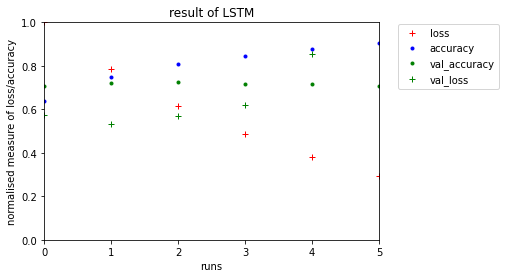

In [89]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(val_loss)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of LSTM')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r+',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.plot(x_len, val_loss, 'g+', label="val_loss")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show


test_acc,test_loss,preds,labels = evaluate(model, test_iterator,"testing")

print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
preds = np.concatenate(preds)
labels = np.concatenate(labels)

prc,rec,fs = precision_score(labels,preds),recall_score(labels,preds),f1_score(labels,preds)
print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Precision: {prc*100:.2f}% | Recall: {rec*100:.2f}% | F1-Score: {fs*100:.2f}%')

# For Setting5: 
**Hyperparameters:**
*   Epoch number=3
*   Learning rate=0.0005
*   batch size= 16
*   Number of nodes in hidden layer = 500

In [90]:
# Hyperparameters
num_epochs = 3
learning_rate = 0.0005

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 500
OUTPUT_DIM = 1
#N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding
BATCH_SIZE = 16

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# keep in mind the sort_key option 
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), sort_key=lambda x: len(x.text),sort_within_batch = True,
    batch_size=BATCH_SIZE,
    device=device)

class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        # embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                
        #hidden = [batch size, hid dim * num directions]
            
        return output

#creating instance of our LSTM_net class

model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM,  
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


model.to(device) #CNN to GPU
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

# training function 
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    bar = pyprind.ProgBar(len(iterator), bar_char='█')
    for batch in iterator:
        
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.tag)
        acc = binary_accuracy(predictions, batch.tag)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        bar.update()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator,mode):
    
    epoch_acc = 0
    epoch_loss=0
    preds,labels=[],[]
    model.eval()
    
    with torch.no_grad():
        bar = pyprind.ProgBar(len(iterator), bar_char='█')
        for batch in iterator:
            
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.tag)
            loss = criterion(predictions, batch.tag)
            
            rounded_preds = torch.round(torch.sigmoid(predictions))
            logits = rounded_preds.detach().cpu().numpy()
            label_ids = batch.tag.to('cpu').numpy()
            
            preds.append(logits)
            labels.append(label_ids)

            epoch_acc += acc.item()
            epoch_loss+=loss.item()
            bar.update()
    if mode =="validation":        
      return epoch_acc / len(iterator),epoch_loss / len(iterator)
    if mode =="testing":
      return epoch_acc / len(iterator),epoch_loss / len(iterator),preds,labels

t = time.time()
loss=[]
acc=[]
val_acc=[]
val_loss=[]
same_loss_count=0
prev_loss = 0
for epoch in range(num_epochs):
    print(f'Epoch Number: {epoch}\n')
    train_loss, train_acc = train(model, train_iterator)
    valid_acc,valid_loss = evaluate(model, valid_iterator,"validation")

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')
    
    #print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    val_loss.append(valid_loss)
    
    if np.abs(prev_loss-valid_loss)<0.001:
      same_loss_count+=1

    prev_loss=valid_loss
    if same_loss_count == 3:
      break
      
print(f'time:{time.time()-t:.3f}')



cuda:0
Epoch Number: 0



/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to 

	Train Loss: 0.626 | Train Acc: 63.91%
	Val. Loss: 0.560 | Val. Acc: 71.44%
Epoch Number: 1




Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:42
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.490 | Train Acc: 74.71%
	Val. Loss: 0.531 | Val. Acc: 72.98%
Epoch Number: 2




Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:42
0% [██████████████████████████████] 100% | ETA: 00:00:00

	Train Loss: 0.381 | Train Acc: 80.86%
	Val. Loss: 0.599 | Val. Acc: 72.07%
time:130.587



Total time elapsed: 00:00:01


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


	Test Loss: 0.618 | Test Acc: 71.64%
	Test Loss: 0.618 | Test Acc: 71.64% | Precision: 74.37% | Recall: 64.98% | F1-Score: 69.36%


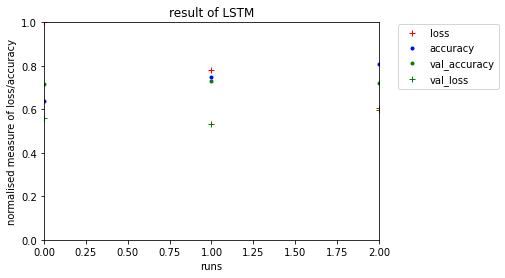

In [91]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(val_loss)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of LSTM')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r+',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.plot(x_len, val_loss, 'g+', label="val_loss")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show


test_acc,test_loss,preds,labels = evaluate(model, test_iterator,"testing")

print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
preds = np.concatenate(preds)
labels = np.concatenate(labels)

prc,rec,fs = precision_score(labels,preds),recall_score(labels,preds),f1_score(labels,preds)
print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Precision: {prc*100:.2f}% | Recall: {rec*100:.2f}% | F1-Score: {fs*100:.2f}%')